In [20]:
from sklearn import tree, metrics
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# load data cleaned from rscript
sc_df = pd.read_csv('../../data/sc_decisions_final.csv', index_col=False)

# fill missing values as they are legitimate
sc_df = sc_df.fillna("N/A")

print(sc_df.shape)

(14047, 24)


# Prepping features for modelling

In [21]:
max_year = sc_df['yearDecision'].max()

# select explanatory and response variables
X = sc_df.loc[:, sc_df.columns != 'direction']
y = sc_df[['direction', 'yearDecision']]

# treat booleans and multiple categories differently
cat_vars = list(X.columns[X.nunique() > 2])
cat_vars.remove('yearDecision')
bool_vars = list(X.columns[X.nunique() == 2])

# encode categorical features
X_cat = pd.get_dummies(X[cat_vars], columns = cat_vars)
X_bool = pd.get_dummies(X[bool_vars], columns = bool_vars, drop_first = True)
X = pd.concat([X_cat, X_bool, X['yearDecision']], axis = 1)

# split train/test by last two years
X_train = X[X['yearDecision'] <= (max_year - 2)]
y_train = y[y['yearDecision'] <= (max_year - 2)]
X_test = X[X['yearDecision'] > (max_year - 2)]
y_test = y[y['yearDecision'] > (max_year - 2)]

# remove yearDecision
X_train = X_train.drop(['yearDecision'], axis=1)
y_train = y_train.drop(['yearDecision'], axis=1)
X_test = X_test.drop(['yearDecision'], axis=1)
y_test = y_test.drop(['yearDecision'], axis=1)

# encode target
y_train['direction'] = y_train.direction.astype('category')
y_test['direction'] = y_test.direction.astype('category')
y_train = y_train.apply(lambda x: x.cat.codes)
y_test = y_test.apply(lambda x: x.cat.codes)

print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)

Training split input-  (12776, 55)
Testing split input-  (1271, 55)


# Modeling

## Find maximum depth
To prevent overfitiing from the start

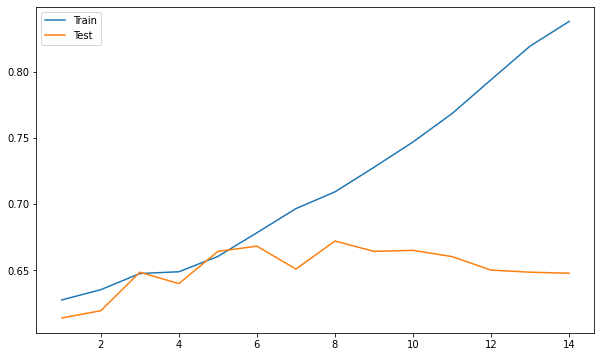

In [22]:
train_scores = []
test_scores = []

# number of trees
depths = [i for i in range(1, 15)] 

# evaluate forest per num trees
for i in depths:
    model = RandomForestClassifier(max_depth=i, n_jobs=-1, random_state = 42)
    model.fit(X_train, np.ravel(y_train))
    
    # evaluate train dataset
    yhat_train = model.predict(X_train)
    train_accuracy = metrics.accuracy_score(y_train, yhat_train)
    train_scores.append(train_accuracy)
    
    # evaluate test dataset
    yhat_test = model.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test, yhat_test)
    test_scores.append(test_accuracy)


# plot training and test results
plt.figure(figsize=(10,6)) 
plt.plot(depths, train_scores, label='Train')
plt.plot(depths, test_scores, label='Test')
plt.legend()
plt.savefig('../../output/validation/year_max_depth_rf.png')

# around 5

## Tune parameters

In [23]:
# wide range considerations for hyperparameters

# num trees in forest
n_estimators = list(range(100, 1000+1, 100))

# num features to consider at every split
max_features = [5, 15, 20, 25]

# max depth of each tree
max_depth = [5]

# min num samples to split a node
min_samples_split = [2, 5, 10]

# min num samples at each leaf node
min_samples_leaf = [2, 4, 6, 8, 10]

# whether bootstrap samples are used
bootstrap = [True, False]

# random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# tune with randomized grid search
model = RandomForestClassifier(random_state = 42)

# random search of parameters with 3 fold CV
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3,
                                  verbose=2, random_state = 42, n_jobs = -1)
# fit the random search model
model_random.fit(X_train, np.ravel(y_train))

model_random.best_params_ # these are narrowed down possible parameter values

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 10,
 'max_features': 25,
 'max_depth': 5,
 'bootstrap': False}

In [24]:
 def evaluate(model, x, y):
    y_hat = model.predict(x)
    accuracy = metrics.accuracy_score(y, y_hat)
    return accuracy
    
# evaluate best random model
best_random = model_random.best_estimator_
random_acc = evaluate(best_random, X_test, y_test)
print('best random model test: {:0.2f}%'.format(100 * random_acc))

# base model
base_model = RandomForestClassifier(random_state = 42, max_depth = 5)
base_model.fit(X_train, np.ravel(y_train))
base_acc = evaluate(base_model, X_test, y_test)
print('base model test: {:0.2f}%'.format(100 * base_acc))

print('Improvement of {:0.2f}%'.format(100 * (random_acc - base_acc) / base_acc)) # (new - old)/old

best random model test: 68.84%
base model test: 66.40%
Improvement of 3.67%


In [25]:
# further narrow down values of hyperparameters
# prev random search should be giving us good approximation

# create parameter grid
param_grid = {
    'bootstrap': [False],
    'max_depth': [5], 
    'max_features': [20, 25, 30],
    'min_samples_leaf': [4, 6, 10],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 300, 400]
}

# create a new model
model_new = RandomForestClassifier(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_new, param_grid = param_grid, cv = 3, 
                           n_jobs = -1, verbose = 2)

# fit grid search to the data
grid_search.fit(X_train, np.ravel(y_train))

grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'bootstrap': False,
 'max_depth': 5,
 'max_features': 30,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'n_estimators': 300}

In [26]:
best_grid = grid_search.best_estimator_
grid_acc = evaluate(best_grid, X_test, y_test)
print('best model test: {:0.2f}%'.format(100 * grid_acc))

print('Improvement of {:0.2f}%.'.format( 100 * (grid_acc - base_acc) / base_acc))

best model test: 68.69%
Improvement of 3.44%.


0.6684408265497809
0.6868607395751377


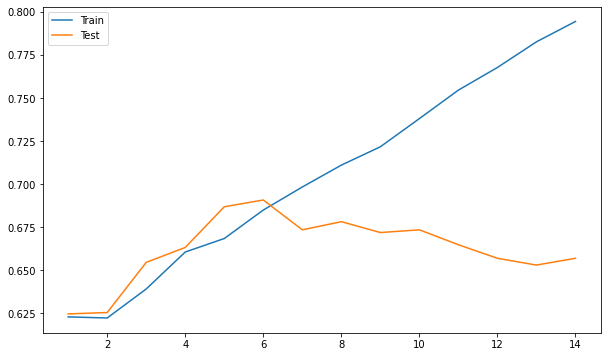

In [27]:
# quick overfitting test check
yhat_train = best_grid.predict(X_train)
train_accuracy = metrics.accuracy_score(y_train, yhat_train)
print(train_accuracy)

yhat_test = best_grid.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, yhat_test)
print(test_accuracy)

# plot
train_scores = []
test_scores = []

# number of trees
depths = [i for i in range(1, 15)] 

# evaluate forest per num trees
for i in depths:
    model = RandomForestClassifier(max_depth=i, n_jobs=-1, random_state = 42, bootstrap = False, max_features = 30, 
                                   min_samples_leaf = 6, min_samples_split = 2, n_estimators = 300)
    model.fit(X_train, np.ravel(y_train))
    
    # evaluate train dataset
    yhat_train = model.predict(X_train)
    train_accuracy = metrics.accuracy_score(y_train, yhat_train)
    train_scores.append(train_accuracy)
    
    # evaluate test dataset
    yhat_test = model.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test, yhat_test)
    test_scores.append(test_accuracy)


# plot training and test results
plt.figure(figsize=(10,6)) 
plt.plot(depths, train_scores, label='Train')
plt.plot(depths, test_scores, label='Test')
plt.legend()
plt.savefig('../../output/validation/year_overfit_rf.png')

#nice

In [28]:
plt.figure(figsize=(200,120)) 
plot_tree(best_grid[0], feature_names = X.columns, 
          class_names =["Conservative", "Liberal"] , filled = True , precision = 4, rounded = True)
plt.savefig('../../output/validation/year_first_rf_tree.png')

# Validation metrics

final model train: 66.84%
final model test: 68.69%
Tuned Model
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       632
           1       0.68      0.70      0.69       639

    accuracy                           0.69      1271
   macro avg       0.69      0.69      0.69      1271
weighted avg       0.69      0.69      0.69      1271



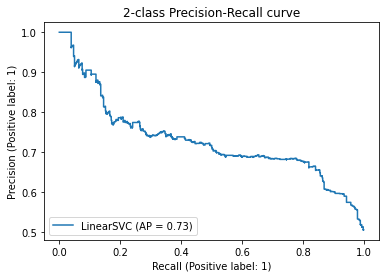

In [29]:
# tuned model (instead of running all of the above)
final_model = RandomForestClassifier(max_depth=5, n_jobs=-1, random_state = 42, bootstrap = False, max_features = 30, 
                                   min_samples_leaf = 6, min_samples_split = 2, n_estimators = 300)
final_model.fit(X_train, np.ravel(y_train))
    
# evaluate train dataset
yhat_train = final_model.predict(X_train)
train_accuracy = metrics.accuracy_score(y_train, yhat_train)
print('final model train: {:0.2f}%'.format(100 * train_accuracy))

# evaluate test dataset
yhat_test = final_model.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, yhat_test)
print('final model test: {:0.2f}%'.format(100 * test_accuracy))

# other metrics for performance 
print("Tuned Model")
print(metrics.classification_report(y_test, yhat_test))

# precision recall curve
display = metrics.PrecisionRecallDisplay.from_estimator(final_model, X_test, y_test, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")
plt.savefig('../../output/validation/Precision-Recall_years.png')